# 🎦**AlloCiné Data Analysis**📊

We had web scraped the [movies](https://github.com/Bastien-LDC/Allocine-Recommender-System/blob/master/Webscraping/Webscraping_Movies_From_AlloCine.ipynb), [series](https://github.com/Bastien-LDC/Allocine-Recommender-System/blob/master/Webscraping/Webscraping_Series_From_AlloCine.ipynb), and [ratings](https://github.com/Bastien-LDC/Allocine-Recommender-System/blob/master/Webscraping/Webscraping_Ratings_From_AlloCine.ipynb) data from the [AlloCiné](https://www.allocine.fr/) website.

**Data description :**

Features|Movies|Series|Ratings
-------|---------|---------|---
`id`|X|X|-
`title`|X|X|-
`status`|-|X|-
`release_date`|X|X|-
`duration`|X|X|-
`nb_seasons`|-|X|-
`nb_episodes`|-|X|-
`genres`|X|X|-
`directors`|X|X|-
`actors`|X|X|-
`nationality`|X|X|-
`press_rating`|X|X|X
`nb_press_rating`|X|X|-
`spect_rating`|X|X|X
`nb_spect_rating`|X|X|-
`summary`|X|X|-
`poster_link`|X|X|-
`user_id`|-|-|X
`(user/press)_name`|-|-|X
`(movie/series)_id`|-|-|X
`date`|-|-|X


If you are interested in, the data for movies and series is available in one csv each: [Webscraping_Movies_Data_allocine_movies.csv](https://storage.cloud.google.com/bucket-bastien/Webscraping/Movies/Data/allocine_movies.csv) and [Webscraping_Series_Data_allocine_series.csv](https://storage.cloud.google.com/bucket-bastien/Webscraping/Series/Data/allocine_series.csv).

---
# **Import libs**

In [656]:
# import libraries
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import os
from warnings import filterwarnings
import missingno as msno

# We ignore reindexing warnings
filterwarnings("ignore",message="Boolean Series key will be reindexed")
%matplotlib inline

# **Data cleaning**

## Saving files

In [657]:
def save_data(df: pd.DataFrame, path:str, name: str):
    '''
    This function saves the dataframe in a csv file.
    :param df: dataframe to save
    :param path: path to save the file
    :param name: name of the file
    :return: None    
    '''
    # We create the folder if not exists
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.to_csv(f"{path}{name}.csv", index=False)
    print(f"File successfully saved in {path}{name}.csv")

## Load the csv files

In [658]:
def load_csv():
    '''
    Load the csv file and return a dict of dataframes.
    '''
    root_path = f"../Saved Data/"
    movies = pd.read_csv(f"{root_path}allocine_movies.csv")
    series = pd.read_csv(f"{root_path}allocine_series.csv")
    press_movies = pd.read_csv(f"{root_path}press_ratings_movies.csv")
    press_series = pd.read_csv(f"{root_path}press_ratings_series.csv")
    user_movies = pd.read_csv(f"{root_path}user_ratings_movies.csv")
    user_series = pd.read_csv(f"{root_path}user_ratings_series.csv")
    return {"movies":movies, "series":series, "press_movies":press_movies, "press_series":press_series, "user_movies":user_movies, "user_series":user_series}
data = load_csv()
movies, series, press_movies, press_series, user_movies, user_series = data["movies"], data["series"], data["press_movies"], data["press_series"], data["user_movies"], data["user_series"]

## Rename and store columns names

In [659]:
# Rename (nb_)spec_rating to (nb_)user_rating
movies.rename(columns={'spect_rating':'user_rating', 'nb_spect_rating':'nb_user_rating'}, inplace=True)
series.rename(columns={'spect_rating':'user_rating', 'nb_spect_rating':'nb_user_rating'}, inplace=True)
# Store columns names
movies_cols = movies.columns.to_list()
series_cols = series.columns.to_list()
press_movies_cols = press_movies.columns.to_list()
press_series_cols = press_series.columns.to_list()
user_movies_cols = user_movies.columns.to_list()
user_series_cols = user_series.columns.to_list()

## Display the first stats

In [661]:
def display_stats(df: pd.DataFrame,chart_type: str):
    '''
    Display the statistics of a dataframe.
    :return: The "description" dataframe.
    '''
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:      
        # Graph of number of missing values by column
        if chart_type == "heatmap":
            msno.heatmap(df, cmap="RdYlBu_r", sort="ascending") # Useful to know the correlation between the missing values
        if chart_type == "bar":
            msno.bar(df, figsize=(12,8), color=(round(rd.random(),2),round(rd.random(),2),round(rd.random(),2)), sort="descending")
        else:
            msno.matrix(df, figsize=(12,8), color=(round(rd.random(),2),round(rd.random(),2),round(rd.random(),2)), sort="descending")
            
        missing_values = missing_values / df.shape[0] * 100
        missing_values = missing_values[missing_values > 0]
        missing_values.sort_values(inplace=True)
        plt.figure(figsize=(12, 5))
        plt.title(f"Percentage of missing values in each column")
        sns.barplot(x=missing_values.index, y=missing_values)
        plt.show()
    else:
        print("No missing values in the dataframe")
    df.info()
    return df.describe()

### Movies

In [662]:
m_unclean = movies.copy()

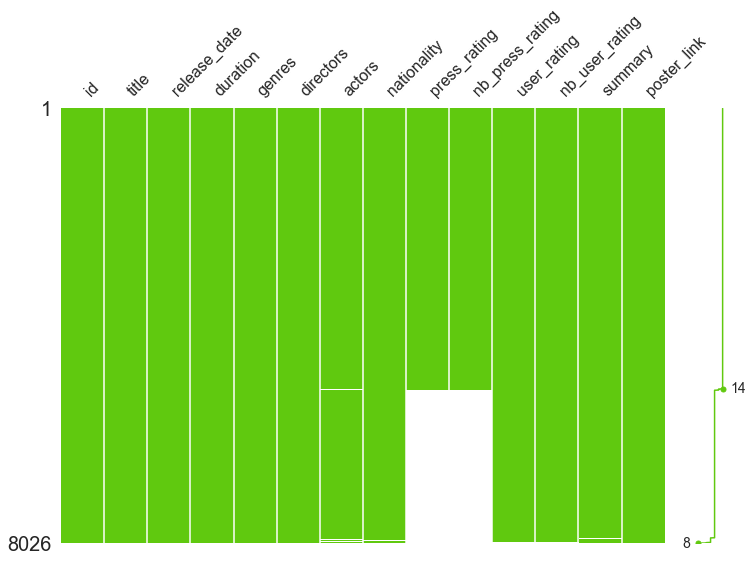

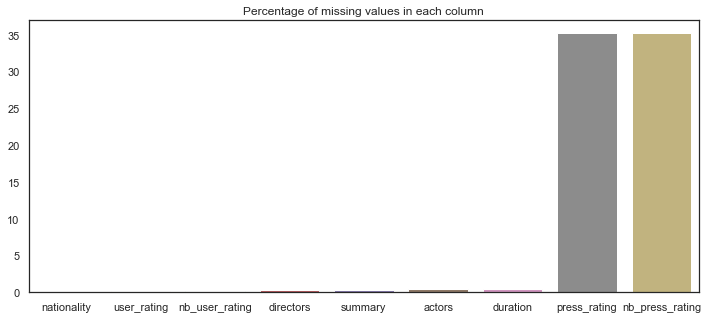

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8026 entries, 0 to 8025
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8026 non-null   int64  
 1   title            8026 non-null   object 
 2   release_date     8026 non-null   object 
 3   duration         7988 non-null   float64
 4   genres           8026 non-null   object 
 5   directors        8005 non-null   object 
 6   actors           7992 non-null   object 
 7   nationality      8018 non-null   object 
 8   press_rating     5200 non-null   float64
 9   nb_press_rating  5200 non-null   float64
 10  user_rating      8017 non-null   float64
 11  nb_user_rating   8017 non-null   float64
 12  summary          8001 non-null   object 
 13  poster_link      8026 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory usage: 878.0+ KB


,id,duration,press_rating,nb_press_rating,user_rating,nb_user_rating
count,8026.000000,7988.000000,5200.000000,5200.000000,8017.000000,8017.000000
mean,150688.183529,107.992489,3.247538,17.497885,3.143059,5613.947362
std,104595.612810,21.608678,0.737270,8.647640,0.733237,13079.942641
min,1.000000,26.000000,1.000000,1.000000,0.800000,1.000000
25%,37259.500000,95.000000,2.800000,11.000000,2.600000,396.000000
50%,176807.500000,104.000000,3.300000,18.000000,3.300000,1511.000000
75%,250685.500000,118.000000,3.700000,24.000000,3.700000,4746.000000
max,303494.000000,450.000000,5.000000,45.000000,4.600000,218842.000000


In [663]:
m_stats = display_stats(m_unclean, "matrix")
m_stats

#### Movies Press Ratings

In [664]:
mp_unclean = press_movies.copy()

In [665]:
mp_stats = display_stats(mp_unclean, "matrix")
mp_stats

No missing values in the dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21582 entries, 0 to 21581
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   press_name    21582 non-null  object 
 1   movie_id      21582 non-null  int64  
 2   press_rating  21582 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 506.0+ KB


,movie_id,press_rating
count,21582.000000,21582.000000
mean,200088.014920,3.446159
std,85667.022665,1.097436
min,62.000000,1.000000
25%,135082.000000,3.000000
50%,230868.000000,4.000000
75%,269758.000000,4.000000
max,299394.000000,5.000000


#### Movies User Ratings

In [666]:
mu_unclean = user_movies.copy()

In [667]:
mu_stats = display_stats(mu_unclean, "matrix")
mu_stats

No missing values in the dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105711 entries, 0 to 105710
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      105711 non-null  object 
 1   user_name    105711 non-null  object 
 2   movie_id     105711 non-null  int64  
 3   user_rating  105711 non-null  float64
 4   date         105711 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 4.0+ MB


,movie_id,user_rating
count,105711.000000,105711.000000
mean,177012.461220,3.302168
std,98340.085009,1.170735
min,62.000000,0.500000
25%,61764.000000,2.500000
50%,218229.000000,3.500000
75%,263209.000000,4.000000
max,302945.000000,5.000000


### Series

In [668]:
s_unclean = series.copy()

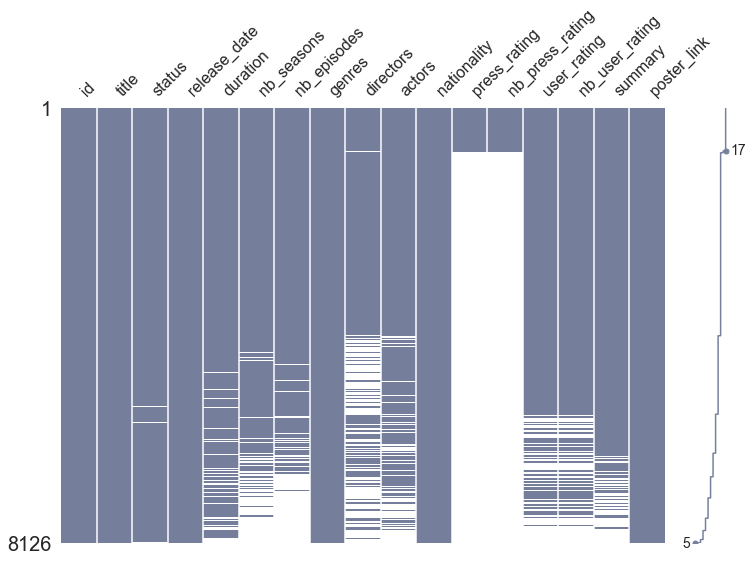

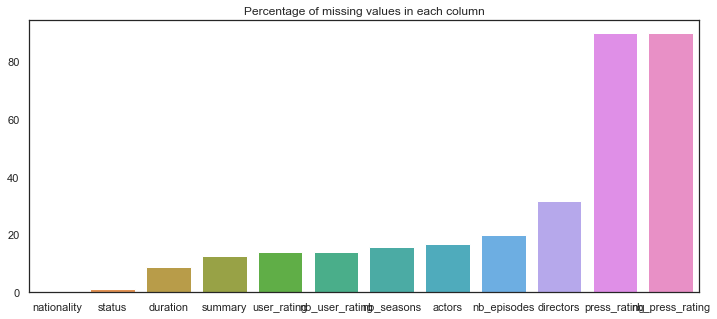

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8126 entries, 0 to 8125
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8126 non-null   int64  
 1   title            8126 non-null   object 
 2   status           8048 non-null   object 
 3   release_date     8126 non-null   object 
 4   duration         7420 non-null   float64
 5   nb_seasons       6859 non-null   float64
 6   nb_episodes      6508 non-null   float64
 7   genres           8126 non-null   object 
 8   directors        5547 non-null   object 
 9   actors           6759 non-null   object 
 10  nationality      8094 non-null   object 
 11  press_rating     833 non-null    float64
 12  nb_press_rating  833 non-null    float64
 13  user_rating      7006 non-null   float64
 14  nb_user_rating   7006 non-null   float64
 15  summary          7117 non-null   object 
 16  poster_link      8126 non-null   object 
dtypes: float64(7),

,id,duration,nb_seasons,nb_episodes,press_rating,nb_press_rating,user_rating,nb_user_rating
count,8126.000000,7420.000000,6859.000000,6508.000000,833.000000,833.000000,7006.000000,7006.000000
mean,15548.236402,40.674798,2.403995,41.359096,3.249100,8.099640,3.273351,990.761205
std,9571.320117,20.811908,3.129590,238.676016,0.616424,3.533958,0.517935,5741.767257
min,1.000000,1.000000,1.000000,1.000000,1.300000,1.000000,0.800000,1.000000
25%,6256.250000,25.000000,1.000000,8.000000,2.900000,6.000000,3.000000,7.000000
50%,17480.500000,42.000000,1.000000,14.000000,3.300000,8.000000,3.200000,37.000000
75%,24203.250000,52.000000,3.000000,38.000000,3.700000,10.000000,3.600000,199.000000
max,31807.000000,240.000000,59.000000,13484.000000,5.000000,30.000000,4.700000,206012.000000


In [669]:
s_stats = display_stats(s_unclean, "matrix")
s_stats

#### Series Press Ratings

In [670]:
sp_unclean = press_series.copy()

In [671]:
sp_stats = display_stats(sp_unclean, "matrix")
sp_stats

No missing values in the dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4516 entries, 0 to 4515
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   press_name    4516 non-null   object 
 1   series_id     4516 non-null   int64  
 2   press_rating  4516 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 106.0+ KB


,series_id,press_rating
count,4516.00000,4516.000000
mean,19829.66519,3.379650
std,6495.73654,0.951869
min,49.00000,0.500000
25%,17464.00000,3.000000
50%,22019.00000,3.500000
75%,24397.00000,4.000000
max,30429.00000,5.000000


#### Series User Ratings

In [672]:
su_unclean = user_series.copy()

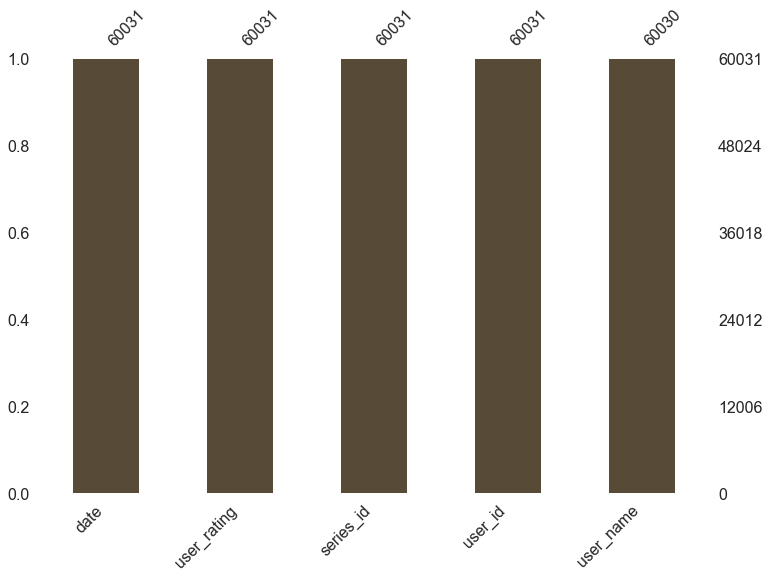

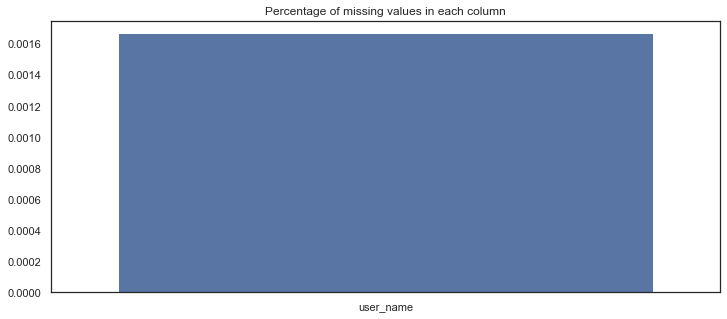

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60031 entries, 0 to 60030
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      60031 non-null  object 
 1   user_name    60030 non-null  object 
 2   series_id    60031 non-null  int64  
 3   user_rating  60031 non-null  float64
 4   date         60031 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 2.3+ MB


,series_id,user_rating
count,60031.000000,60031.000000
mean,15515.704053,3.584356
std,9351.003920,1.421383
min,4.000000,0.500000
25%,7634.000000,2.500000
50%,18752.000000,4.000000
75%,23563.000000,5.000000
max,31644.000000,5.000000


In [673]:
su_stats = display_stats(user_series, "bar")
su_stats

## Drop duplicates and other

In [674]:
m_duplicates = movies.duplicated(subset=["id"]).sum()
s_duplicates = series.duplicated(subset=["id"]).sum()
pm_duplicates = press_movies.duplicated().sum()
ps_duplicates = press_series.duplicated().sum()
um_duplicates = user_movies.duplicated().sum()
us_duplicates = user_series.duplicated().sum()
print(f"Nb of movie duplicates: {m_duplicates}")
print(f"Nb of series duplicates: {s_duplicates}")
print(f"Nb of press movie duplicates: {pm_duplicates}")
print(f"Nb of press series duplicates: {ps_duplicates}")
print(f"Nb of user movie duplicates: {um_duplicates}")
print(f"Nb of user series duplicates: {us_duplicates}")
series.drop_duplicates(subset=["id"], inplace=True, ignore_index=True)
movies.drop_duplicates(subset=["id"], inplace=True, ignore_index=True)
press_movies.drop_duplicates(inplace=True, ignore_index=True)
press_series.drop_duplicates(inplace=True, ignore_index=True)
user_movies.drop_duplicates(inplace=True, ignore_index=True)
user_series.drop_duplicates(inplace=True, ignore_index=True)
print("--> All duplicates removed")

Nb of movie duplicates: 119
Nb of series duplicates: 125
Nb of press movie duplicates: 649
Nb of press series duplicates: 158
Nb of user movie duplicates: 2463
Nb of user series duplicates: 2184
--> All duplicates removed


In [675]:
# Drop series with "Divers" as genre (lots of missing values)
series.drop(series[series.genres.apply(lambda x: "Divers" in x)].index, inplace=True)
# Drop series with "Datedesortieinconnue" as release_date
series.drop(series[series.release_date == "Datedesortieinconnue"].index, inplace=True)
series.reset_index(drop=True, inplace=True)

## Convert the strings to arrays

In [676]:
def convert_to_array(df: pd.DataFrame):
    '''
    Convert the strings to arrays
    '''
    df["genres"] = df["genres"].apply(lambda x: x.split(", ") if type(x) not in [float,list] else x)
    df["directors"] = df["directors"].apply(lambda x: x.split(", ") if type(x) not in [float,list] else x)
    df["actors"] = df["actors"].apply(lambda x: x.split(", ") if type(x) not in [float,list] else x)
    df["nationality"] = df["nationality"].apply(lambda x: x.split(", ") if type(x) not in [float,list] else x)

In [677]:
convert_to_array(movies)
convert_to_array(series)

## Create new tables

### *GENRE*

#### *Create `genres` dataframes*

In [678]:
def create_genre_df(df_key: str):
    '''
    Create a dataframe that contains information about each genre.
    :param df_key: The dataframe to get the genres from (movies or series).
    :return: The movies or series genre dataframe.
    '''
    # Get dataframe from key
    df = data.get(df_key)
    genre_df = None
    if df is not None:  
        df = df.copy()      
        # Remove all rows with no genres
        df.dropna(subset=["genres"], inplace=True)
        # Get all unique genres from df
        genres_list = [genre.lstrip() for genres in df["genres"] for genre in genres]
        genres_list = sorted(list(set(genres_list))) 

        # Create dataframe with the number of movies/series per genre from genres_list
        genre_df = pd.DataFrame({"genres": genres_list, f"nb_{df_key}": [df[df["genres"].apply(lambda x: genre in x).values].shape[0] for genre in genres_list]})

        # Add the average duration per genre
        genre_df["avg_duration"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["duration"].mean()) for genre in genres_list]

        # Add the median duration per genre
        genre_df["median_duration"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["duration"].median()) for genre in genres_list]

        # Add the nb_press_rating and nb_user_rating to the genre_df
        genre_df["nb_press_rating"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["nb_press_rating"].sum()) for genre in genres_list]
        genre_df["nb_user_rating"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["nb_user_rating"].sum()) for genre in genres_list]

        # Add the total_rating to the genre_df (press_rating + user_rating)
        genre_df["total_rating"] = genre_df["nb_press_rating"] + genre_df["nb_user_rating"]

        # Add the press_rating_percentage and user_rating_percentage to the genre_df 
        genre_df["press_rating_percentage"] = round(genre_df["nb_press_rating"] / genre_df["nb_press_rating"].values.sum() * 100, 3)
        genre_df["user_rating_percentage"] = round(genre_df["nb_user_rating"] / genre_df["nb_user_rating"].values.sum() * 100, 3)

        # Add the movies/series_percentage to the genre_df
        genre_df[f"{df_key}_percentage"] = round(genre_df[f"nb_{df_key}"]/df.shape[0] * 100, 3)
        # Return the genre_df sorted by genre
        return genre_df.sort_values(by = "genres", ascending = True)

In [679]:
m_genres_df = create_genre_df("movies")
s_genres_df = create_genre_df("series")

In [680]:
print(m_genres_df.genres.values)
print(s_genres_df.genres.values)

['Action' 'Animation' 'Arts Martiaux' 'Aventure' 'Biopic' 'Bollywood'
 'Comédie' 'Comédie dramatique' 'Comédie musicale' 'Divers' 'Drame'
 'Epouvante-horreur' 'Erotique' 'Espionnage' 'Expérimental' 'Famille'
 'Fantastique' 'Guerre' 'Historique' 'Judiciaire' 'Musical' 'Policier'
 'Péplum' 'Romance' 'Science fiction' 'Sport event' 'Thriller' 'Western']
['Action' 'Animation' 'Arts Martiaux' 'Aventure' 'Biopic' 'Classique'
 'Comédie' 'Comédie dramatique' 'Comédie musicale' 'Dessin animé'
 'Documentaire' 'Drama' 'Drame' 'Epouvante-horreur' 'Erotique'
 'Espionnage' 'Famille' 'Fantastique' 'Guerre' 'Historique' 'Judiciaire'
 'Mobisode' 'Musical' 'Médical' 'Policier' 'Péplum' 'Romance'
 'Science fiction' 'Show' 'Soap' 'Sport event' 'Thriller' 'Websérie'
 'Western']


#### *Save all `genres` dataframes*

In [681]:
path = "../Cleaned Data/"
save_data(m_genres_df, path, "m_genres")
save_data(s_genres_df, path, "s_genres")

File successfully saved in ../Cleaned Data/m_genres.csv
File successfully saved in ../Cleaned Data/s_genres.csv


### *NATIONALITY*

#### *Create `nationality` dataframes*

In [682]:
def create_nationality_df(df_key: str):
    '''
    Create a dataframe that contains information about each nationality.
    :param df_key: The dataframe to get the nationalities from (movies or series).
    :return: The movies or series nationality dataframe.
    '''
    # Get dataframe from key
    df = data.get(df_key)
    nation_df = None
    if df is not None:        
        df = df.copy()
        # Remove all rows with no nationality
        df.dropna(subset=["nationality"], inplace=True)
        # Get all unique nationality from df
        nationality = [nat.lstrip() for nationality in df["nationality"] for nat in nationality]
        nationality = sorted(list(set(nationality))) 
        # Create dataframe with the number of movies/series per nationality from nationality list
        nation_df = pd.DataFrame({"nationality": nationality, f"nb_{df_key}": [df[df["nationality"].apply(lambda x: nation in x).values].shape[0] for nation in nationality]})

        # Add the nb_press_rating and nb_user_rating to the nation_df
        nation_df["nb_press_rating"] = [int(df[df["nationality"].apply(lambda x: nation in x).values]["nb_press_rating"].sum()) for nation in nationality]
        nation_df["nb_user_rating"] = [int(df[df["nationality"].apply(lambda x: nation in x).values]["nb_user_rating"].sum()) for nation in nationality]

        # Add the total_rating to the nation_df (press_rating + user_rating)
        nation_df["total_rating"] = nation_df["nb_press_rating"] + nation_df["nb_user_rating"]

        # Add the press_rating_percentage and user_rating_percentage to the nation_df 
        nation_df["press_rating_percentage"] = round(nation_df["nb_press_rating"] / nation_df["nb_press_rating"].values.sum() * 100, 4)
        nation_df["user_rating_percentage"] = round(nation_df["nb_user_rating"] / nation_df["nb_user_rating"].values.sum() * 100, 4)

        # Add the movies/series_percentage to the nation_df
        nation_df[f"{df_key}_percentage"] = round(nation_df[f"nb_{df_key}"]/df.shape[0] * 100, 4)
        return nation_df.sort_values(by = "nationality", ascending = True)

In [683]:
m_nationality_df = create_nationality_df("movies")
s_nationality_df = create_nationality_df("series")

In [684]:
print(m_nationality_df.nationality.values)
print(s_nationality_df.nationality.values)

['Albania' 'Algeria' 'Argentina' 'Armenia' 'Australia' 'Austria' 'Belgium'
 'Benin' 'Bolivia' 'Bosnia' 'Botswana' 'Brazil' 'Bulgaria' 'Byelorussia'
 'Cambodia' 'Canada' 'Chad' 'Chile' 'China' 'Colombia' 'Croatia' 'Cuba'
 'Cyprus' 'Czech Republic' 'Czechoslovakia' 'Denmark' 'Dominican Republic'
 'Egypt' 'Estonia' 'Ethiopia' 'Finland' 'France' 'Georgia' 'Germany'
 'Greece' 'Guatemala' 'Guinea' 'Haiti' 'Hongkong' 'Hungary' 'Iceland'
 'India' 'Indonesia' 'Iran' 'Ireland' 'Israel' 'Italy' 'Ivory Coast'
 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Korea' 'Kosovo' 'Laos' 'Latvia'
 'Lebanon' 'Libia' 'Liechtenstein' 'Lithuania' 'Luxembourg' 'Malawi'
 'Malaysia' 'Malta' 'Mauritania' 'Mexico' 'Monaco' 'Mongolia' 'Morocco'
 'Nepal' 'Netherlands' 'New Zealand' 'Nigeria' 'Norway' 'Pakistan'
 'Palestine' 'Panama' 'Paraguay' 'Peru' 'Philippines' 'Poland' 'Portugal'
 'Qatar' 'Romania' 'Russia' 'Rwanda' 'Samoa' 'Saudi Arabia' 'Senegal'
 'Serbia' 'Singapore' 'Slovakia' 'Slovenia' 'Somalia' 'South Africa'
 'So

#### *Save all `nationality` dataframes*

In [685]:
path = "../Cleaned Data/"
save_data(m_nationality_df, path, "m_nationality")
save_data(s_nationality_df, path, "s_nationality")

File successfully saved in ../Cleaned Data/m_nationality.csv
File successfully saved in ../Cleaned Data/s_nationality.csv


## Check data coherence

### Impute missing duration

In [686]:
def impute_missing_duration(df_key: str):
    '''
    From the m/s_genres_df DataFrames, we order the genres by the number of movies/series with that genre.
    We then compute the median duration of the movies/series with that genre.
    Finally, we impute the missing duration of the movies/series with the median duration of the movies/series with the most popular genre among their genres.
    :param df_key: Key of the dataframe in the data dictionary to impute the missing duration.
    :return: The imputed dataframe.
    '''
    # Get dataframe from key
    df = data.get(df_key)
    genres_df = m_genres_df if df_key == "movies" else s_genres_df if df_key == "series" else None
    if df is not None:
        df = df.copy()
        # Get the movies/serie with missing duration
        df_na_duration = df[df["duration"].isna()]
        for index, row in df_na_duration.iterrows():
            # Get the genre rows of each movies/series from the m/s_genres_df DataFrame
            na_duration_genres = genres_df.loc[genres_df.genres.isin(row["genres"])]
            # Get the genre with the most movies/series from the na_duration_genres DataFrame
            most_pop_genre = na_duration_genres.sort_values(by = f"nb_{df_key}", ascending = False).iloc[0]["genres"]
            # Retrieve the median duration of the movies/series with the most popular genre
            median_duration = int(genres_df[genres_df.genres == most_pop_genre].median_duration)
            # Impute the missing duration of the movies/series with the median duration of the most popular genre
            df.loc[index, "duration"] = median_duration
    return df

### Series

In [687]:
series = impute_missing_duration("series")

#### Drop missing ratings and NaN threshold

In [688]:
# Drop series with no press AND no user ratings
s_na_ratings = series[series["press_rating"].isna()][series["user_rating"].isna()].shape[0]
series.dropna(subset=["nb_press_rating","nb_user_rating","press_rating","user_rating"], inplace=True, how="all")
series.reset_index(drop=True, inplace=True)
print(f"Number of series with no ratings: {s_na_ratings}")
print("--> All series with no ratings removed")

Number of series with no ratings: 1100
--> All series with no ratings removed


In [689]:
# Drop series with at least na_thresh missing values
na_thresh = 7
# Dataframe with series with at least na_thresh missing values
s_na_thresh = series[series.apply(lambda x: sum(x.isna()) >= na_thresh, axis=1)]
series.drop(index=s_na_thresh.index, inplace=True)
series.reset_index(drop=True, inplace=True)
print(f"Number of series with at least {na_thresh} missing values: {len(s_na_thresh)}")
print(f"--> All series with at least {na_thresh} missing values removed")

Number of series with at least 7 missing values: 222
--> All series with at least 7 missing values removed


#### Change `release_date` format

In [690]:
# Replace the release_date string by the release year as a date 
# Get all the 4-digits numbers from a string and keep only the first one, which is the release year. 
series["release_date"] = series["release_date"].apply(lambda x: int(re.findall(r"\d{4}", x)[0]))

In [691]:
# Find the series where nb_seasons is greater or equal to nb_episodes 
series[series.nb_seasons > series.nb_episodes].shape

(11, 17)

### Movies

In [692]:
movies = impute_missing_duration("movies")

#### Drop missing ratings

In [698]:
# Drop series and movies with no press AND no user ratings
m_na_ratings = movies[movies["press_rating"].isna()][movies["user_rating"].isna()].shape[0]
movies.dropna(subset=["nb_press_rating","nb_user_rating","press_rating","user_rating"], inplace=True, how="all")
movies.reset_index(drop=True, inplace=True)
print(f"Number of movies with no ratings: {m_na_ratings}")
print("--> All movies with no ratings removed")

Number of movies with no ratings: 0
--> All movies with no ratings removed


#### Get the release season date

In [647]:
def get_release_season(date: str):
    '''
    Get the release season date (eg: from "2019-05-10" return "Spring")
    :param date: Date to get the release season from.
    :return: The release season.
    '''
    spring = "03-21"
    summer = "06-21"
    fall = "09-21"
    winter = "12-21"
    my = re.sub(r"\d{4}-", "", date)
    if my < spring or my >= winter:
        return "Winter"
    elif my < summer and my >= spring:
        return "Spring"
    elif my < fall and my >= summer:
        return "Summer"
    elif my < winter and my >= fall:
        return "Fall"

In [648]:
# Keep only the year and the month of the release date
# movies["release_date"] = movies["release_date"].apply(lambda x: x.split("-")[0]+"-"+x.split("-")[1])
# date_test = movies["release_date"].apply(lambda x: x.split("-")[0])

# Get the release season
movies["release_season"] = movies["release_date"].apply(lambda x: get_release_season(x) + " " + x.split("-")[0])
movies_cols = movies_cols[:3] + ["release_season"] + movies_cols[3:]
movies = movies[movies_cols]

## Display the last stats

### Movies

In [649]:
m_clean = movies.copy()

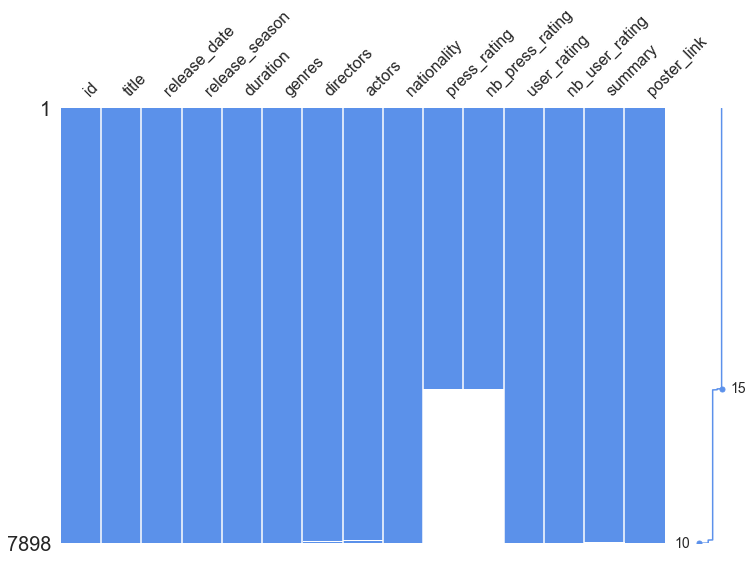

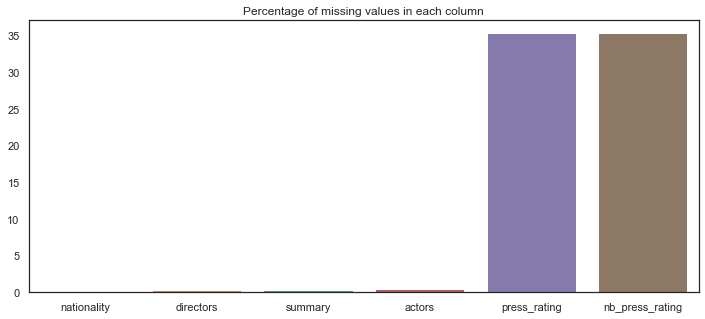

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7898 entries, 0 to 7906
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7898 non-null   int64  
 1   title            7898 non-null   object 
 2   release_date     7898 non-null   object 
 3   release_season   7898 non-null   object 
 4   duration         7898 non-null   float64
 5   genres           7898 non-null   object 
 6   directors        7878 non-null   object 
 7   actors           7864 non-null   object 
 8   nationality      7890 non-null   object 
 9   press_rating     5111 non-null   float64
 10  nb_press_rating  5111 non-null   float64
 11  user_rating      7898 non-null   float64
 12  nb_user_rating   7898 non-null   float64
 13  summary          7875 non-null   object 
 14  poster_link      7898 non-null   object 
dtypes: float64(5), int64(1), object(9)
memory usage: 987.2+ KB


,id,duration,press_rating,nb_press_rating,user_rating,nb_user_rating
count,7898.000000,7898.000000,5111.000000,5111.000000,7898.000000,7898.000000
mean,150481.210180,107.923018,3.247388,17.464880,3.140491,5563.583059
std,104553.465455,21.594608,0.738463,8.656134,0.732848,12946.183790
min,1.000000,26.000000,1.000000,1.000000,0.800000,1.000000
25%,37106.250000,95.000000,2.800000,11.000000,2.600000,394.000000
50%,176718.000000,104.000000,3.300000,18.000000,3.200000,1501.500000
75%,250618.750000,118.000000,3.700000,24.000000,3.700000,4724.750000
max,303494.000000,450.000000,5.000000,45.000000,4.600000,218842.000000


In [650]:
m_stats = display_stats(m_clean, chart_type="matrix")
m_stats

### Series

In [651]:
s_clean = series.copy()

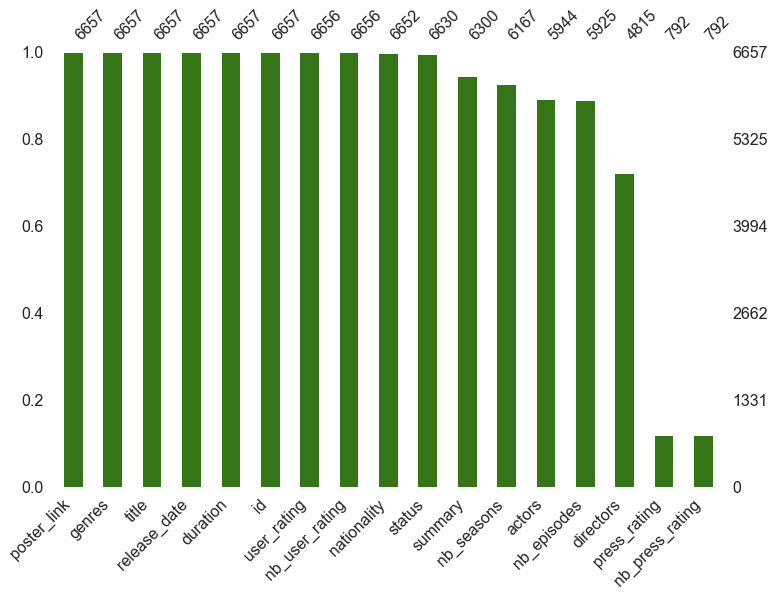

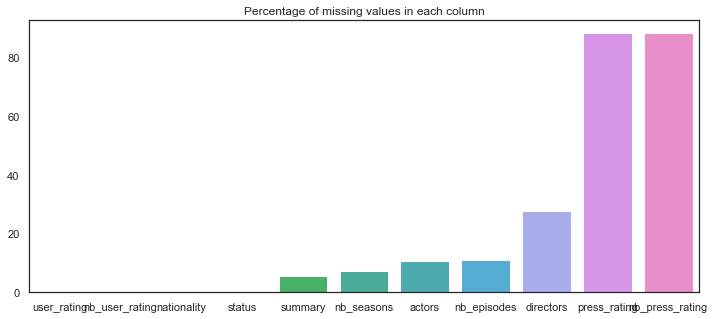

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6657 entries, 0 to 6656
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               6657 non-null   int64  
 1   title            6657 non-null   object 
 2   status           6630 non-null   object 
 3   release_date     6657 non-null   int64  
 4   duration         6657 non-null   float64
 5   nb_seasons       6167 non-null   float64
 6   nb_episodes      5925 non-null   float64
 7   genres           6657 non-null   object 
 8   directors        4815 non-null   object 
 9   actors           5944 non-null   object 
 10  nationality      6652 non-null   object 
 11  press_rating     792 non-null    float64
 12  nb_press_rating  792 non-null    float64
 13  user_rating      6656 non-null   float64
 14  nb_user_rating   6656 non-null   float64
 15  summary          6300 non-null   object 
 16  poster_link      6657 non-null   object 
dtypes: float64(7),

,id,release_date,duration,nb_seasons,nb_episodes,press_rating,nb_press_rating,user_rating,nb_user_rating
count,6657.000000,6657.000000,6657.000000,6167.000000,5925.000000,792.000000,792.000000,6656.000000,6656.000000
mean,15276.507436,2009.598918,41.008112,2.477055,43.618565,3.245202,8.095960,3.275451,995.076322
std,9688.876993,12.827121,20.261614,3.240308,249.846859,0.611625,3.528591,0.521327,5819.471164
min,1.000000,1929.000000,1.000000,1.000000,1.000000,1.300000,1.000000,0.800000,1.000000
25%,5654.000000,2005.000000,25.000000,1.000000,8.000000,2.800000,6.000000,3.000000,8.000000
50%,17401.000000,2014.000000,42.000000,1.000000,16.000000,3.300000,8.000000,3.200000,39.000000
75%,24143.000000,2019.000000,52.000000,3.000000,39.000000,3.700000,10.000000,3.600000,200.000000
max,31747.000000,2022.000000,240.000000,59.000000,13484.000000,5.000000,30.000000,4.700000,206012.000000


In [654]:
s_stats = display_stats(s_clean,chart_type="bar")
s_stats

## Save Cleaned datasets

In [ ]:
path = "../Cleaned Data/"
for k,v in data.items():
    save_data(v, path, k)

---
# **Section 1. Ratings Distributions**


## Plot the Distribution of Ratings 

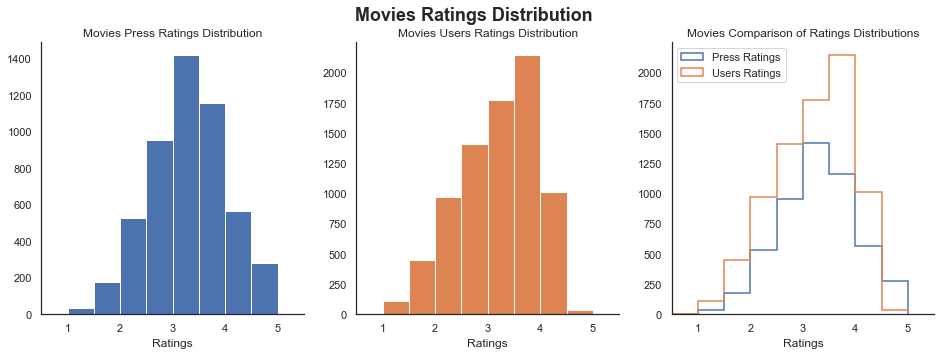

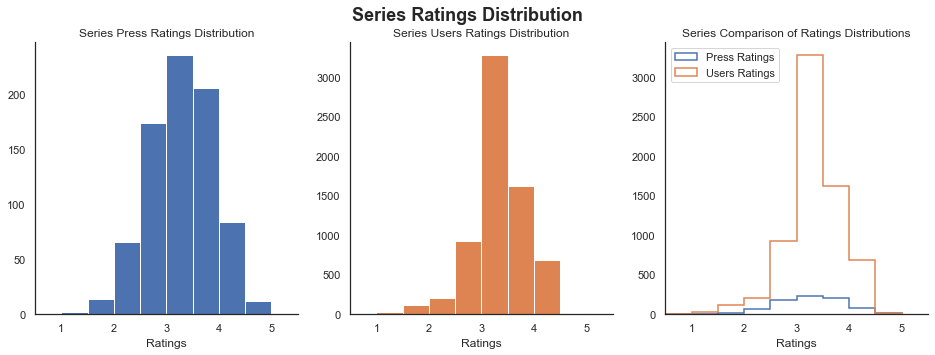

In [476]:
for k,df in list(data.items())[:2]:
    sns.set(style="white", palette="deep")

    fig, axes = plt.subplots(1, 3, figsize = (16,5))
    fig.suptitle(f"{k.title()} Ratings Distribution", fontsize=18, fontweight='bold')
    ax1, ax2, ax3 = fig.axes

    ax1.set_xlim([0.5,5.5])
    ax2.set_xlim([0.5,5.5])
    ax3.set_xlim([0.5,5.5])


    ax1.hist(df["press_rating"], bins = 10, range = (0,5), color='C0') # bin range = 1
    ax1.set_title(f'{k.title()} Press Ratings Distribution')
    ax1.set_xlabel('Ratings')

    ax2.hist(df["user_rating"], bins = 10, range = (0,5), color='C1') # bin range = 1
    ax2.set_title(f'{k.title()} Users Ratings Distribution')
    ax2.set_xlabel('Ratings')

    ax3.hist(df["press_rating"], bins = 10, range = (0,5), histtype = 'step', 
            lw=1.5, label='Press Ratings', color='C0')
    ax3.hist(df["user_rating"], bins = 10, range = (0,5), histtype = 'step', 
            lw=1.5, label='Users Ratings', color='C1')
    ax3.legend(loc = 'upper left')
    ax3.set_title(f'{k.title()} Comparison of Ratings Distributions')
    ax3.set_xlabel('Ratings')

    for ax in fig.axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    # Save the figure
    fig.savefig(f"{k}_rating_dist.png", bbox_inches='tight', dpi=200)

## Ratings Correlation

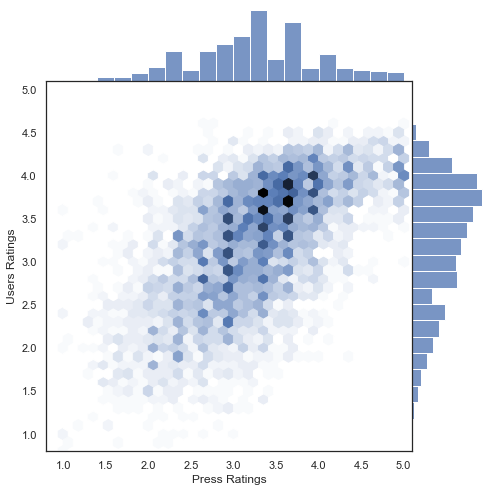

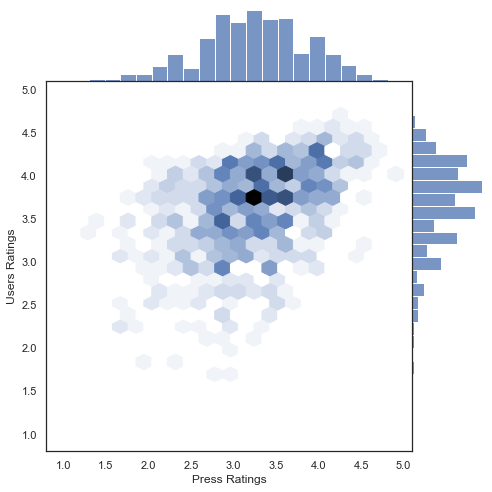

In [477]:
# Correlation between press_rating and user_rating
for k,df in list(data.items())[:2]:
    ax = sns.jointplot(x="press_rating", y="user_rating", 
                    data=df, kind="hex",
                    marginal_kws=dict(bins=20),
                    xlim=(0.8,5.1), ylim=(0.8,5.1),
                    height=7, space=0).set_axis_labels("Press Ratings", "Users Ratings")
    
    # save the fig
    #ax.savefig('allocine-1_jointplot.png', bbox_inches='tight', dpi=200)

## Compare press to users ratings


MOVIES USER RATINGS TIER DISTRIBUTION
      user_rating
0.33          2.8
0.66          3.6
0.0 % of the Movies with the highest press ratings received a low users ratings.
4.95 % of the Movies with the highest press ratings received a moderate users ratings.
95.05 % of the Movies with the highest press ratings received a high users ratings.

SERIES USER RATINGS TIER DISTRIBUTION
      user_rating
0.33          3.1
0.66          3.4
0.0 % of the Series with the highest press ratings received a low users ratings.
0.0 % of the Series with the highest press ratings received a moderate users ratings.
100.0 % of the Series with the highest press ratings received a high users ratings.


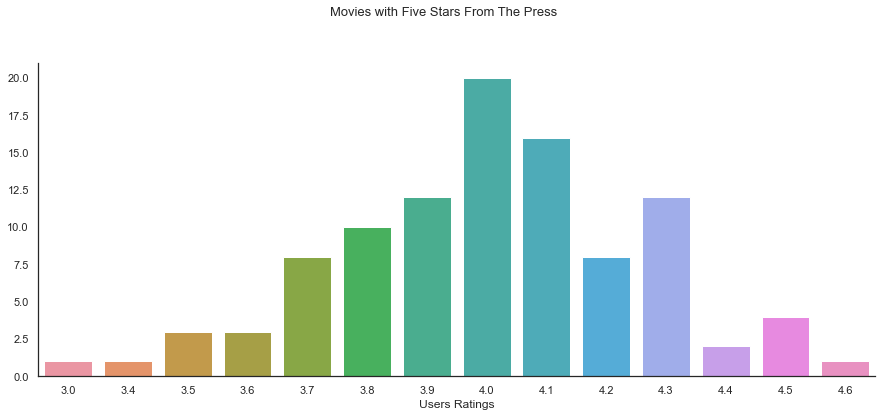

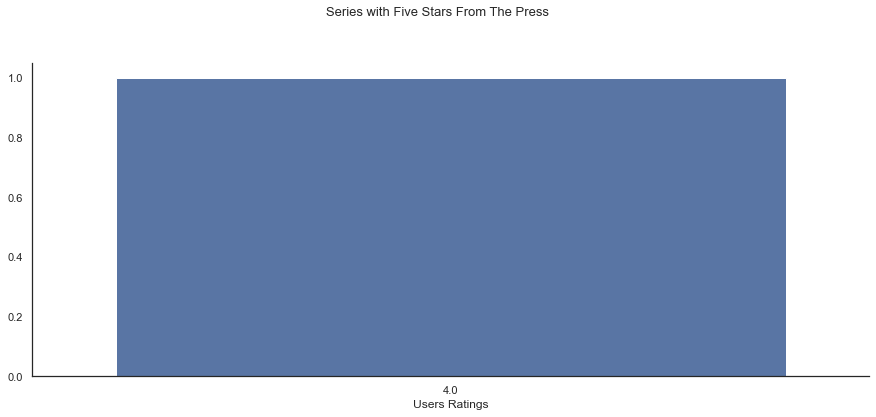

In [494]:
for k,df in list(data.items())[:2]:
    five_stars = df[df["press_rating"] >= 5]
    f, ax = plt.subplots(figsize=(15,6))
    f.suptitle(f'{k.title()} with Five Stars From The Press', 
            fontsize=13)
    f.subplots_adjust(top=0.85)

    sns.countplot(x=five_stars["user_rating"], ax=ax)
    ax.set_xlabel("Users Ratings")
    ax.set_ylabel("")
    sns.despine(top=True, right=True, left=False, bottom=False)
    
    ### print the first tier and second tier of the Users Ratings
    print(f"\n{k.upper()} USER RATINGS TIER DISTRIBUTION")
    quant = df[["user_rating"]].quantile([.33,.66])
    print(quant)
    
    p = (len(five_stars[(five_stars["user_rating"] < quant.values[0][0])]) / len(five_stars)) * 100
    print(f'{round(p, 2)} % of the {k.title()} with the highest press ratings received a low users ratings.')
    p = (len(five_stars[(five_stars["user_rating"] < quant.values[1][0]) & (five_stars["user_rating"] >= quant.values[0][0])]) / len(five_stars)) * 100
    print(f'{round(p, 2)} % of the {k.title()} with the highest press ratings received a moderate users ratings.')
    p = (len(five_stars[five_stars["user_rating"] >= quant.values[1][0]]) / len(five_stars)) * 100
    print(f'{round(p, 2)} % of the {k.title()} with the highest press ratings received a high users ratings.')
    
    ### save the fig
    # f.savefig('allocine-2_hist5stars.png', bbox_inches='tight', dpi=200)